In [1]:
library(tidyverse)
library(cowplot)
library(ggExtra)
library(ggbeeswarm)

`%+replace%` <- ggplot2::`%+replace%`

theme_zietzm <- function(base_size = 11.5, base_family = "") {
    # Starts with theme_bw and then modify some parts
    # Theme options are documentated at http://docs.ggplot2.org/current/theme.html
    ggplot2::theme_classic(base_size = base_size, base_family = base_family) %+replace%
    ggplot2::theme(

        strip.background  = ggplot2::element_rect(fill = NA, colour = 'grey90', size = 0),
        strip.text = element_text(vjust = 1, size = 10),
        plot.margin       = ggplot2::margin(t=2, r=2, b=2, l=2, unit='pt'),
        legend.spacing     = grid::unit(0.1, 'cm'),
        legend.key        = ggplot2::element_blank(),
        panel.border=element_rect(fill = NA, color = 'black', size = 0.5), 
        axis.line=element_line(size=0),
    )
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



## Calibration curves

In [2]:
full_cal_bins <- read_csv('../../data/task1/calibration/hetionet_calibration_bins.csv')
sampled_cal_bins <- read_csv('../../data/task1/calibration/hetionet_calibration_bins_sampled.csv')

Parsed with column specification:
cols(
  expected_frac = col_double(),
  lower_ci = col_double(),
  upper_ci = col_double(),
  feature = col_character(),
  feature_value = col_double(),
  metaedge = col_character()
)
Parsed with column specification:
cols(
  expected_frac = col_double(),
  lower_ci = col_double(),
  upper_ci = col_double(),
  feature = col_character(),
  feature_value = col_double(),
  metaedge = col_character()
)


In [3]:
full_cal_bins <- full_cal_bins %>%
    mutate(feature = feature %>% recode_factor(scaled_degree = 'Scaled degree',
                                               analytic_prior = 'Approximate prior',
                                               xswap_prior = 'Edge prior'))

sampled_cal_bins <- sampled_cal_bins %>%
    mutate(feature = feature %>% recode_factor(scaled_degree = 'Scaled degree',
                                               analytic_prior = 'Approximate prior',
                                               xswap_prior = 'Edge prior'))

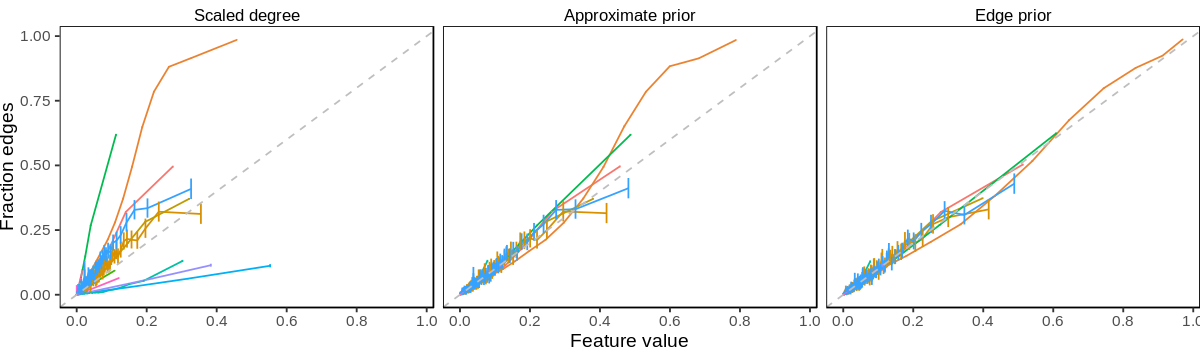

In [4]:
options(repr.plot.width=10, repr.plot.height=3)

full_calibration_plot <- (
    ggplot(full_cal_bins, aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                              ymax = upper_ci, color = metaedge))
    + geom_line()
    + geom_errorbar()
    + geom_abline(color = 'grey', linetype = 'dashed')
    + facet_wrap(vars(feature), nrow = 1)
    + theme_zietzm()
    + ylab('Fraction edges')
    + xlab('Feature value')
    + theme(legend.position = "none", plot.margin = unit(c(0.2, 0, 0.2, 0), "cm"))
    + scale_x_continuous(breaks = c(0, 0.2, 0.4, 0.6, 0.8, 1))
)

sampled_calibration_plot <- (
    ggplot(sampled_cal_bins, aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                              ymax = upper_ci, color = metaedge))
    + geom_line()
    + geom_errorbar()
    + geom_abline(color = 'grey', linetype = 'dashed')
    + facet_wrap(vars(feature),  nrow = 1)
    + theme_zietzm()
    + ylab('Fraction edges')
    + xlab('Feature value')
    + theme(legend.position = "none", plot.margin = unit(c(0.2, 0, 0.2, 0), "cm"))
)
    
full_calibration_plot

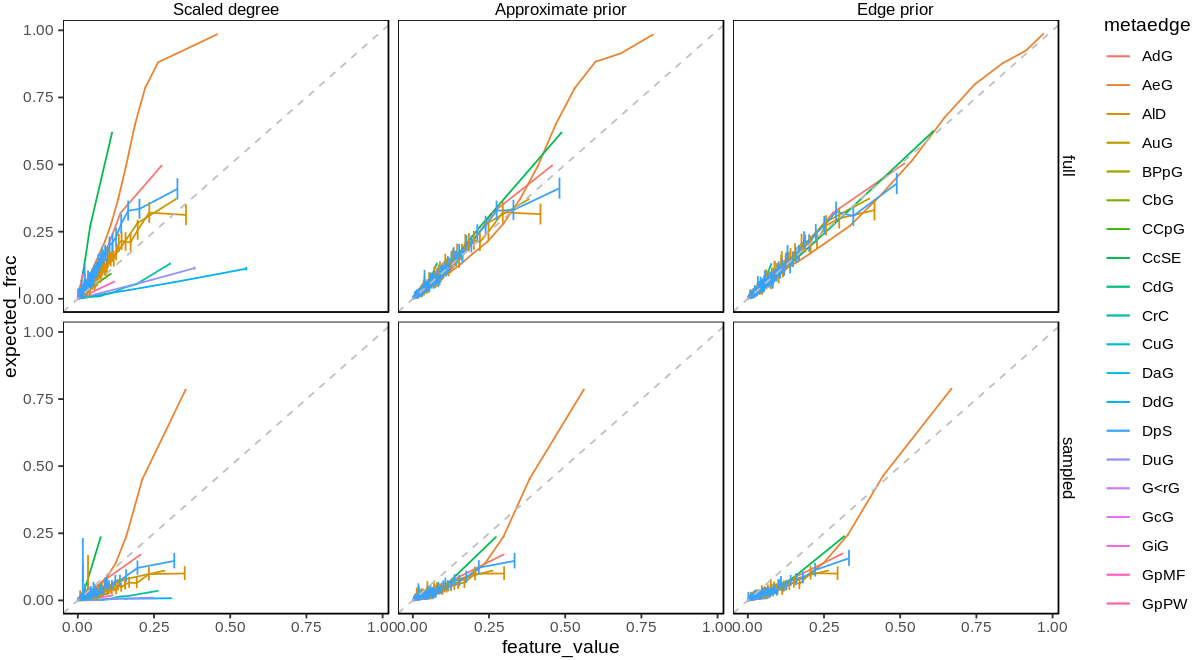

In [5]:
options(repr.plot.width=10, repr.plot.height=5.5)


calibration_plot <- bind_rows(
    full_cal_bins %>% mutate(network = 'full'),
    sampled_cal_bins %>% mutate(network = 'sampled')
) %>% 
ggplot(aes(x = feature_value, y = expected_frac, ymin = lower_ci, 
                ymax = upper_ci, color = metaedge)) + 
geom_line() + 
geom_errorbar() + 
geom_abline(color = 'grey', linetype = 'dashed') + 
facet_grid(rows = vars(network), cols = vars(feature)) +
theme_zietzm()

calibration_plot

## Calibration metrics

In [6]:
metrics <- read_csv('../../data/task1/calibration/hetionet_calibration_metrics.csv')

metrics %>% head

Parsed with column specification:
cols(
  network = col_character(),
  metaedge = col_character(),
  feature = col_character(),
  cal = col_double(),
  ref = col_double(),
  brier = col_double(),
  auroc = col_double()
)


network,metaedge,feature,cal,ref,brier,auroc
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
full,AdG,xswap_prior,0.0005348332,0.007573513,0.008108346,0.9893918
full,AdG,analytic_prior,0.0006444262,0.007571256,0.008215682,0.9891555
full,AdG,scaled_degree,0.0015091243,0.007574097,0.009083222,0.9891437
full,AeG,xswap_prior,0.0011463458,0.018729566,0.019875912,0.9873503
full,AeG,analytic_prior,0.0045910898,0.018719604,0.023310694,0.9868655
full,AeG,scaled_degree,0.0195552381,0.018735534,0.038290772,0.9868530


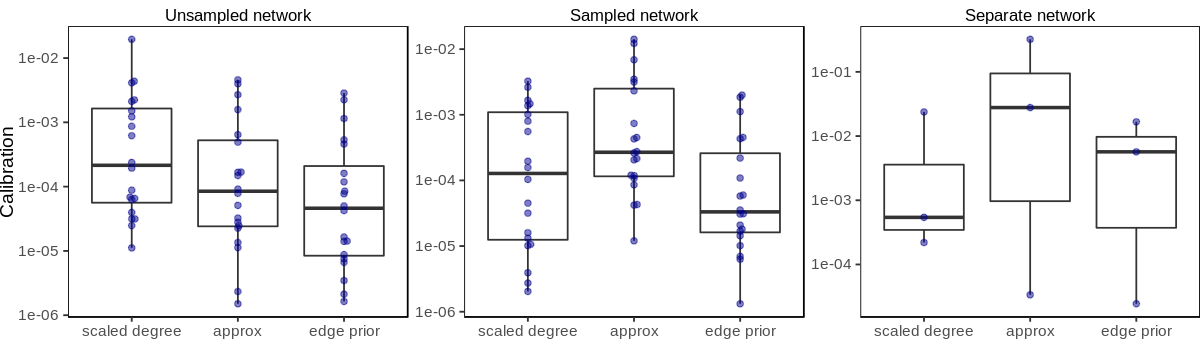

In [7]:
options(repr.plot.width=10, repr.plot.height=3)

all_cal <- (
    ggplot(metrics %>%
               mutate(
                   network = network %>% recode_factor(full = 'Unsampled network', 
                                                       sampled = 'Sampled network', 
                                                       other = 'Separate network'),
                   feature = feature %>% recode_factor(scaled_degree = 'scaled degree', 
                                                       analytic_prior = 'approx',
                                                       xswap_prior = 'edge prior'),
               ), 
           aes(x = feature, y = cal))
    + facet_wrap(vars(network), scales = 'free_y')
    + geom_boxplot(outlier.shape = NA)
    + geom_beeswarm(alpha = 0.5, color = 'darkblue')
    + theme_zietzm()
    + scale_y_log10()
    + theme(plot.margin = unit(c(0.2, 0, 0, 0), "cm"))
    + xlab("") 
    + ylab("Calibration")
)

all_cal

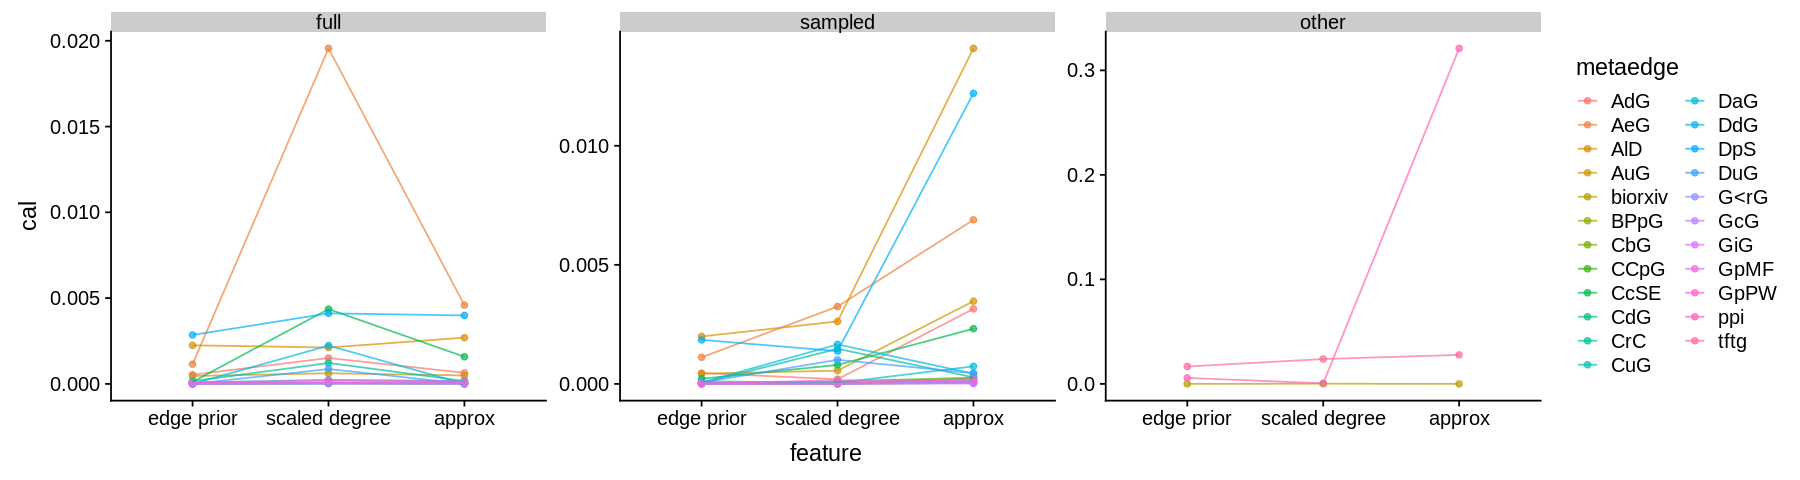

In [8]:
options(repr.plot.width=15, repr.plot.height=4)

(
    ggplot(metrics %>%
               mutate(
                   network = network %>% factor(levels = c('full', 'sampled', 'other')),
                   feature = feature %>% recode_factor(xswap_prior = 'edge prior', 
                                                       scaled_degree = 'scaled degree', 
                                                       analytic_prior = 'approx'),
               ), 
           aes(x = feature, y = cal, group = metaedge, color = metaedge))
    + facet_wrap(vars(network), scales = 'free_y')
    + geom_point(alpha = 0.7)
    + geom_line(alpha = 0.7)
)

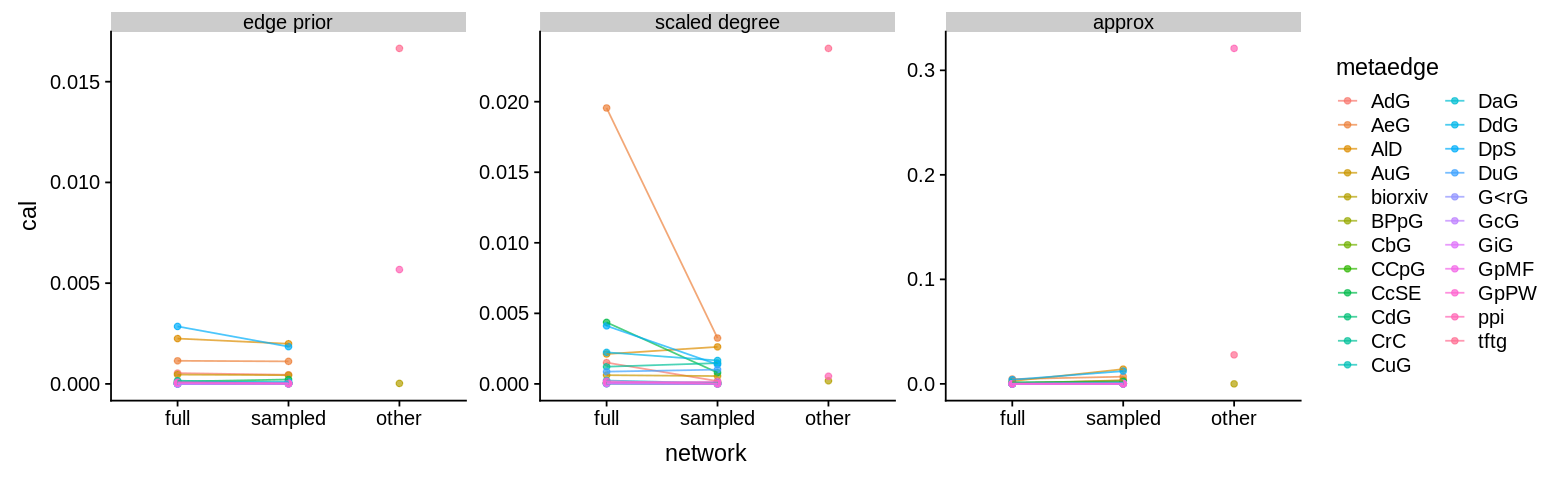

In [9]:
options(repr.plot.width=13, repr.plot.height=4)

(
    ggplot(metrics %>%
               mutate(
                   network = network %>% factor(levels = c('full', 'sampled', 'other')),
                   feature = feature %>% recode_factor(xswap_prior = 'edge prior', 
                                                       scaled_degree = 'scaled degree', 
                                                       analytic_prior = 'approx'),
               ), 
           aes(x = network, y = cal, group = metaedge, color = metaedge))
    + facet_wrap(vars(feature), scales = 'free_y')
    + geom_point(alpha = 0.7)
    + geom_line(alpha = 0.7)
)

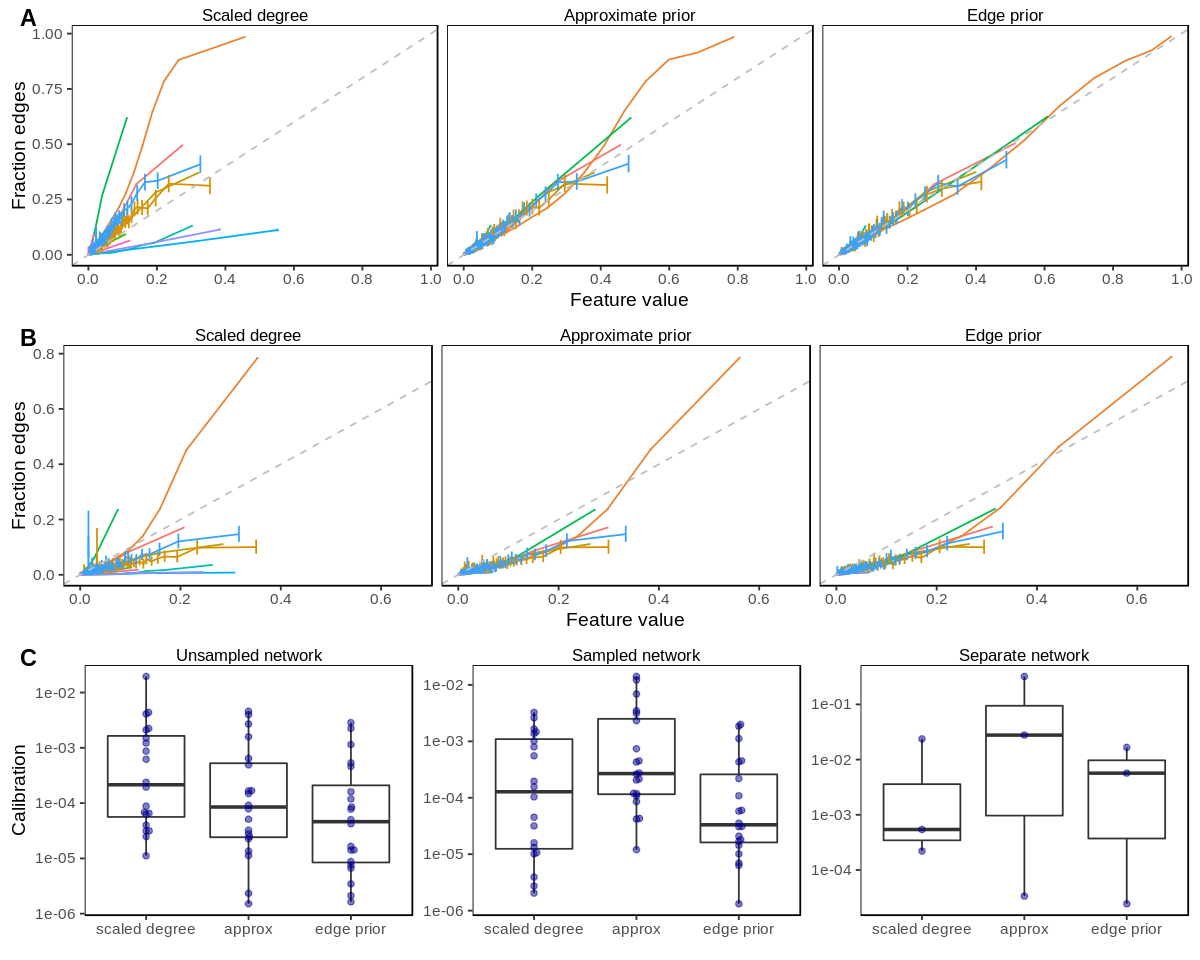

In [12]:
options(repr.plot.width=10, repr.plot.height=8)

calibration_figure <- plot_grid(
    full_calibration_plot, 
    sampled_calibration_plot, 
    all_cal, 
    ncol = 1, labels = c("A", "B", "C")) + 
    theme(plot.margin = unit(c(0, 0.25, 0, 0.25), 'cm'))


ggsave(filename = '../../img/fig4.calibration.png', plot = calibration_figure, 
       dpi = 300, width = 9, height = 8)
calibration_figure